In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import h5py, os, tqdm, glob
os.environ['XLA_PYTHON_CLIENT_MEM_FRACTION'] = '0.49'
import numpy as np
import matplotlib.pyplot as plt

import jax
import jax.numpy as jnp
import optax
from flax import nnx
import orbax.checkpoint as ocp

from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split

from jaxpm.painting import cic_paint, cic_read, compensate_cic
from jaxpm.utils import power_spectrum
from jaxpm.utils import _initialize_pk
from jaxpm.pm import linear_field, lpt, make_ode_fn, pm_forces
from jaxpm.kernels import fftk, gradient_kernel, invlaplace_kernel, longrange_kernel, invnabla_kernel
from jaxpm.nn import MLP, ResNet3D, ResNetBlock3D
from jaxpm import camels

jax.devices("gpu")

[cuda(id=0)]

In [3]:
parts_per_dim = 64
mesh_per_dim = parts_per_dim
mesh_shape = [mesh_per_dim] * 3

## Loading the snapshots

In [4]:
# i_snapshots=range(1, 33+4, 4)
i_snapshots=[-2,-1]

In [5]:
SIM = "/cluster/work/refregier/athomsen/flatiron/CAMELS/Sims/IllustrisTNG/CV/CV_0"

train_dict = camels.load_CV_snapshots(
    SIM,
    mesh_per_dim,
    parts_per_dim,
    i_snapshots=i_snapshots,
)

Using snapshots ['/cluster/work/refregier/athomsen/flatiron/CAMELS/Sims/IllustrisTNG/CV/CV_0/snapshot_088.hdf5', '/cluster/work/refregier/athomsen/flatiron/CAMELS/Sims/IllustrisTNG/CV/CV_0/snapshot_090.hdf5']
Selecting 262144 dark matter (deterministic)
Selecting 262144 gas particles (random)


loading snapshots: 100%|██████████| 2/2 [00:22<00:00, 11.24s/it]


In [6]:
SIM = "/cluster/work/refregier/athomsen/flatiron/CAMELS/Sims/IllustrisTNG/CV/CV_1"

test_dict = camels.load_CV_snapshots(
    SIM,
    mesh_per_dim,
    parts_per_dim,
    # i_snapshots=range(1, 33+4, 4),
    i_snapshots=i_snapshots,
)

Using snapshots ['/cluster/work/refregier/athomsen/flatiron/CAMELS/Sims/IllustrisTNG/CV/CV_1/snapshot_088.hdf5', '/cluster/work/refregier/athomsen/flatiron/CAMELS/Sims/IllustrisTNG/CV/CV_1/snapshot_090.hdf5']
Selecting 262144 dark matter (deterministic)
Selecting 262144 gas particles (random)


loading snapshots: 100%|██████████| 2/2 [00:21<00:00, 10.85s/it]


# functions

In [7]:
# vmap over the snapshots
vcic_paint = jax.vmap(cic_paint, in_axes=(None,0,None))
vcic_read = jax.vmap(cic_read, in_axes=(0,0))

def preprocess(snapshot_dict):
    cosmo = snapshot_dict["cosmo"]
    scales = snapshot_dict["scales"]
    gas_Ps = snapshot_dict["gas_Ps"]
    
    # rho (exactly like in PM)
    rho_dm = vcic_paint(jnp.zeros(mesh_shape), snapshot_dict["dm_poss"], None)
    rho_gas = vcic_paint(jnp.zeros(mesh_shape), snapshot_dict["gas_poss"], cosmo.Omega_b / cosmo.Omega_c)
    rho = rho_dm + rho_gas
    gas_rho = vcic_read(rho, snapshot_dict["gas_poss"])
    
    # fscalar
    kvec = fftk(mesh_shape)
    delta_k = jax.vmap(jnp.fft.rfftn, in_axes=0)(rho)
    fscalar = jax.vmap(jnp.fft.irfftn, in_axes=0)(delta_k * invnabla_kernel(kvec))
    gas_fscalar = vcic_read(fscalar, snapshot_dict["gas_poss"])

    return scales, rho, gas_rho, fscalar, gas_fscalar, gas_Ps


In [8]:
def normalized_paint(positions, weights):
    rho_pos = cic_paint(jnp.zeros([mesh_per_dim] * 3), positions)
    pos_rho = cic_read(rho_pos, positions)

    return cic_paint(jnp.zeros(mesh_shape), positions, weights/pos_rho)

def plot_field(field, ax, vlims=None):
    log_sum = jnp.log10(field.sum(axis=0))

    if vlims is None:
        vmin, vmax = log_sum.min(), log_sum.max()
        vlims = (vmin, vmax)
    else:
        vmin, vmax = vlims
    
    return ax.imshow(log_sum, cmap="magma", vmin=vmin, vmax=vmax), vlims, log_sum

In [9]:
def get_train_step(model, optimizer):

    @jax.jit
    def train_step(params, opt_state, batch):
        x, y = batch
    
        def loss_fn(params):
            model = nnx.merge(graphdef, params)
            y_pred = model(x)
            loss = jnp.mean((y - y_pred) ** 2)
            return loss
        
        loss, grads = jax.value_and_grad(loss_fn)(params)
    
        updates, opt_state = optimizer.update(grads, opt_state, params)
        params = optax.apply_updates(params, updates)
    
        return params, opt_state, loss

    return train_step


## particle-level MLP (HPM connection)

In [10]:
def get_particle_level(snapshot_dict, flatten=True):
    scales, rho, gas_rho, fscalar, gas_fscalar, gas_Ps = preprocess(snapshot_dict)

    X = jnp.stack(
        [
            jnp.tile(scales, (parts_per_dim**3, 1)).T, 
            np.log10(gas_rho),
            np.arcsinh(gas_fscalar/100)
        ], 
        axis=-1
    )
    Y = jnp.stack([np.log10(gas_Ps)], axis=-1)

    if flatten:
        X = X.reshape(-1, X.shape[-1])
        Y = Y.reshape(-1, Y.shape[-1])

    return X, Y

In [11]:
X, Y = get_particle_level(train_dict)
mlp = MLP(X.shape[-1], Y.shape[-1], 64, 4, nnx.Rngs(0))

total_steps = 1_000
batch_size = 1_024
learning_rate = 1e-3
# learning_rate = optax.cosine_decay_schedule(
#     init_value=1e-3, 
#     decay_steps=total_steps, 
#     alpha=0.1
# )
clip_norm = 1

optimizer = optax.chain(
    optax.clip_by_global_norm(clip_norm),
    optax.adam(learning_rate)
)
losses = []

graphdef, params = nnx.split(mlp)
opt_state = optimizer.init(params)

train_step = get_train_step(mlp, optimizer)

### training

100%|██████████| 1000/1000 [00:02<00:00, 359.91it/s]


[None]

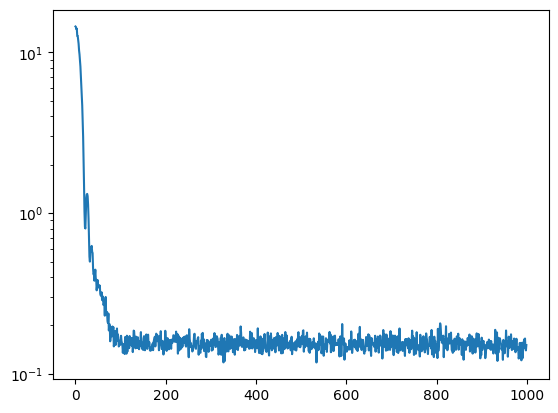

In [12]:
for i in tqdm.tqdm(range(total_steps)):
    inds = np.random.choice(X.shape[0], batch_size)
    batch = (X[inds], Y[inds])
    
    params, opt_state, loss = train_step(params, opt_state, batch)
    losses.append(loss)

mlp = nnx.merge(graphdef, params)

fig, ax = plt.subplots()
ax.plot(losses)
ax.set(yscale="log")

## pixel-level CNN

In [13]:
def get_pixel_level(snapshot_dict):
    scales, rho, gas_rho, fscalar, gas_fscalar, gas_Ps = preprocess(snapshot_dict)

    # P_gas = jax.vmap(
    #     cic_paint, in_axes=(None,0,0)
    # )(jnp.zeros(mesh_shape), snapshot_dict["gas_poss"], gas_Ps/gas_rho)

    P_gas = jax.vmap(normalized_paint, in_axes=(0,0))(snapshot_dict["gas_poss"], gas_Ps)

    X = jnp.stack([rho, fscalar], axis=-1)
    Y = jnp.log10(1 + P_gas)

    return X, Y

In [14]:
X, Y = get_pixel_level(train_dict)

In [15]:
Y.min(), Y.max(), Y.mean()

(Array(0., dtype=float32),
 Array(7.362287, dtype=float32),
 Array(0.83505654, dtype=float32))

In [16]:
Y.shape

(2, 64, 64, 64)

In [17]:
X.shape

(2, 64, 64, 64, 2)

In [18]:
# # in_fields = rho_gas[...,jnp.newaxis]
# X = jnp.stack([rho_tot, fscalar_tot], axis=-1)

# P_gas = jax.vmap(
#     cic_paint, in_axes=(None,0,0)
# )(jnp.zeros(mesh_shape), gas_poss, gas_Ps/gas_rho)

# # TODO apply log?
# # Y = jnp.log1p(P_gas)
# Y = jnp.log10(1 + P_gas)

In [19]:
# block = ResNetBlock3D(
#     channels=16, 
#     kernel_size=(3,3,3), 
#     strides=1, 
#     rngs=nnx.Rngs(0),
# )

In [20]:
# model = ResNet3D(
#     d_in=2,
#     d_hidden=16, 
#     d_out=1, 
#     strides=1,
#     num_blocks=3, 
#     rngs=nnx.Rngs(0),
# )

In [21]:
class Conv3D(nnx.Module):
    def __init__(
        self,
        d_in: int,
        d_hidden: int,
        d_out: int,
        num_layers: int,
        rngs: nnx.Rngs,
        kernel_size: tuple = (3, 3, 3),
        strides: int = 1,
    ):
        self.conv_in = nnx.Conv(d_in, d_hidden, kernel_size, 1, padding="SAME", rngs=rngs)
        self.conv_hidden = [nnx.Conv(d_hidden, d_hidden, kernel_size, 1, padding="SAME", rngs=rngs) for _ in range(num_layers)]
        self.conv_out = nnx.Conv(d_hidden, d_out, kernel_size, 1, padding="SAME", rngs=rngs)

    def __call__(self, x, training: bool = False):
        x = self.conv_in(x)
        # x = self.norm(x, use_running_average=not training)
        
        x = jax.nn.relu(x)
        for hidden in self.conv_hidden:
            x = hidden(x)
            x = jax.nn.relu(x)

        x = self.conv_out(x)
        x = jnp.squeeze(x)

        return x

In [22]:
# total_steps = 10_000
# batch_size = 64
# learning_rate = 1e-3
# # learning_rate = optax.cosine_decay_schedule(
# #     init_value=1e-3, 
# #     decay_steps=total_steps, 
# #     alpha=0.1
# # )
# clip_norm = 1

# optimizer = optax.chain(
#     optax.clip_by_global_norm(clip_norm),
#     optax.adam(learning_rate)
# )
# losses = []

In [23]:
X, Y = get_pixel_level(train_dict)
cnn = Conv3D(
    d_in=2, 
    d_hidden=16, 
    d_out=1, 
    num_layers=5, 
    rngs=nnx.Rngs(0)
)

total_steps = 30_000
# learning_rate = 1e-3
learning_rate = optax.cosine_decay_schedule(
    init_value=1e-3, 
    decay_steps=total_steps, 
    alpha=0.1
)
clip_norm = 1

optimizer = optax.chain(
    optax.clip_by_global_norm(clip_norm),
    optax.adam(learning_rate)
)
losses = []

graphdef, params = nnx.split(mlp)
opt_state = optimizer.init(params)

train_step = get_train_step(mlp, optimizer)

100%|██████████| 30000/30000 [02:08<00:00, 233.52it/s]


[None]

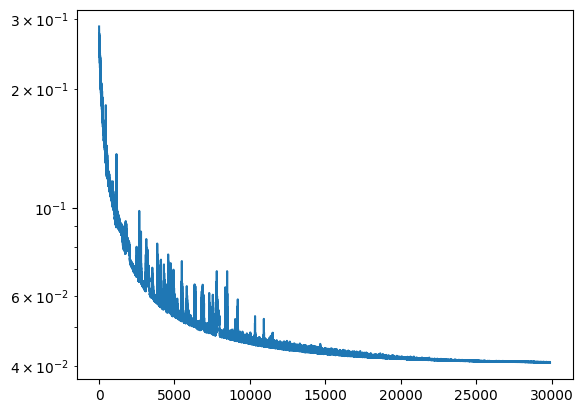

In [24]:
graphdef, params = nnx.split(cnn)
opt_state = optimizer.init(params)

@jax.jit
def train_step(params, opt_state, batch):
    x, y = batch

    def loss_fn(params):
        cnn = nnx.merge(graphdef, params)
        y_pred = cnn(x)
        loss = jnp.mean((y - y_pred) ** 2)
        return loss
    
    loss, grads = jax.value_and_grad(loss_fn)(params)

    updates, opt_state = optimizer.update(grads, opt_state, params)
    params = optax.apply_updates(params, updates)

    return params, opt_state, loss

for i in tqdm.tqdm(range(total_steps)):
    # TODO
    batch = (X[0][jnp.newaxis], Y[0][jnp.newaxis])
    
    params, opt_state, loss = train_step(params, opt_state, batch)
    losses.append(loss)

cnn = nnx.merge(graphdef, params)

fig, ax = plt.subplots()
ax.plot(losses[100:])
ax.set(yscale="log")

# testing

In [49]:
def plot_comparison(true_field, pred_field, true_label="CAMELS", pred_label="", quantity_label="P", suptitle=""):
    fig, ax = plt.subplots(figsize=(3*6, 6+1), ncols=3)
    
    im, vlims, true_field_log_sum = plot_field(true_field, ax[0])
    ax[0].set(title=true_label)
    
    im, _, pred_field_log_sum = plot_field(pred_field, ax[1], vlims=vlims)
    ax[1].set(title="particle-level")
    
    fig.colorbar(im, ax=ax[:2], label=f"log(sum({quantity_label}))", orientation="horizontal", shrink=0.6, aspect=20)
        
    residual = true_field_log_sum - pred_field_log_sum
    lim = np.max(np.abs(residual[np.isfinite(residual)]))
    print(lim)
    im = ax[2].imshow(residual, cmap="seismic", vmin=-lim, vmax=lim)
    ax[2].set(title="residual (true - pred)")
    fig.colorbar(im, ax=ax[2], label=f"log(sum({quantity_label}_1)) - log(sum({quantity_label}_2))", orientation="horizontal", shrink=0.6, aspect=10)
    
    for i in range(len(ax)):
        ax[i].set_yticks([])
        ax[i].set_xticks([])
    
    fig.suptitle(suptitle, fontsize=16)

In [50]:
snapshot_dict = test_dict
suptitle = "CV = testing"

# snapshot_dict = train_dict
# suptitle = "CV = training"

i_scale = 0

## particle-level

### MLP

In [31]:
X_test, Y_test = get_particle_level(snapshot_dict, flatten=False)

gas_pos = snapshot_dict["gas_poss"][i_scale]
gas_P_test = jnp.squeeze(10**mlp(X_test))
P_mlp = normalized_paint(gas_pos, gas_P_test[i_scale])

P_camels = normalized_paint(gas_pos, snapshot_dict["gas_Ps"][i_scale])

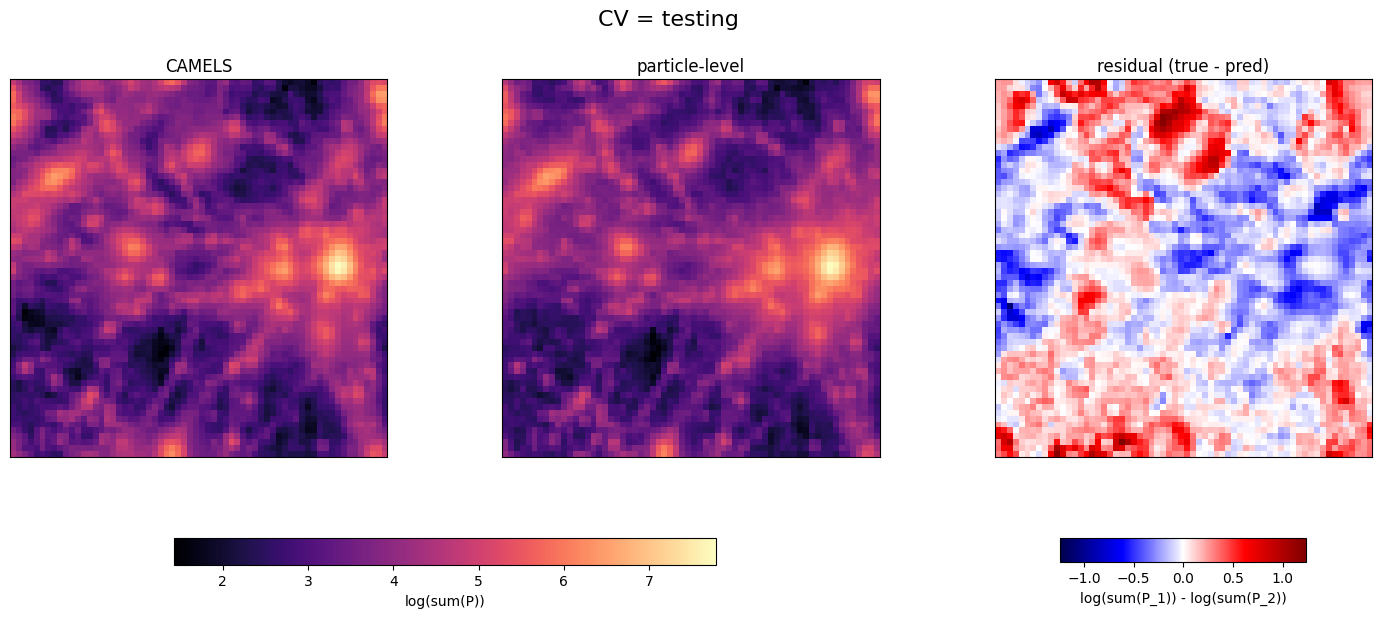

In [33]:
plot_comparison(P_camels, P_mlp, pred_label="particle MLP", suptitle=suptitle)

### GNN

### pixel-level CNN

In [51]:
X_test, Y_test = get_pixel_level(snapshot_dict)
P_cnn = jnp.squeeze(10**cnn(X_test) - 1)[i_scale]

32.626457


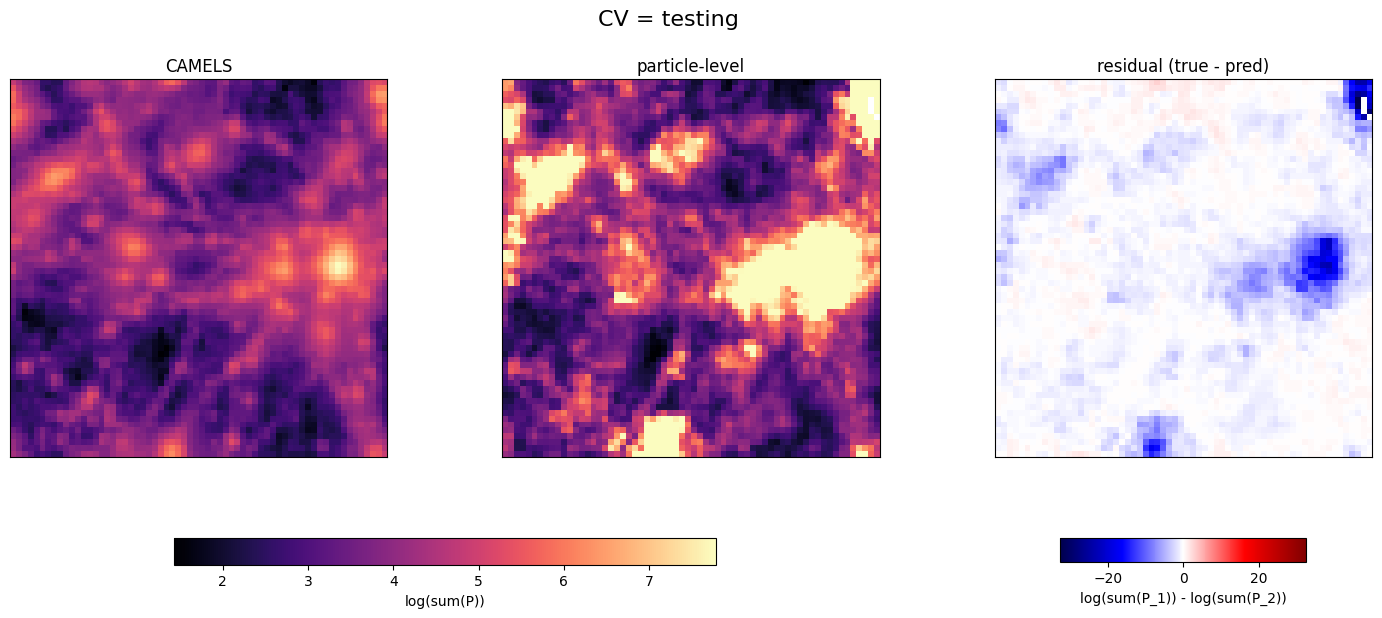

In [52]:
plot_comparison(P_camels, P_cnn, pred_label="field CNN", suptitle=suptitle)